# Fit BAO peak from input correlation function

In [1]:
import numpy as np

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 14})

from pycorr import TwoPointCorrelationFunction, TwoPointEstimator, NaturalTwoPointEstimator, project_to_multipoles, project_to_wp, utils, setup_logging
from cosmoprimo import *

from densitysplit import catalog_data, density_split
from bin.density_split_mocks_functions import split_density, compute_densitySplit_CCF
from densitysplit.pk_model import *
from densitysplit.utils import *
from densitysplit.corr_func import *

# To activate logging
setup_logging()

## Data and output directories

In [2]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [3]:
#catalog_name = 'AbacusSummit_1Gpc_z1.175'
#bias = 1.8

catalog_name = 'AbacusSummit_2Gpc_z1.175'
#bias = 3.

#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')
catalog.shift_boxcenter(-catalog.offset)

In [4]:
z = catalog.redshift

# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()
f = bg.Omega_m(z)**0.55

## Load correlation function poles

In [5]:
ells = [0, 2]
nells = len(ells)

### Density split

In [6]:
nsplits = 3
nmocks = 1000
abacus_split_results = np.load(output_dir+catalog.name+'_densitySplit_rh_CCFs_cellsize10_randomsize4_RSD.npy', allow_pickle=True)
mocks_split_results = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_1000_mocks_densitySplit_rh_CCF_cellsize10_randomsize4_RSD_all.npy', allow_pickle=True)

In [7]:
_, split_cov = get_split_poles(mocks_split_results, ells, nsplits)
split_xiell = [abacus_split_results[split].get_corr(ells=ells, return_sep=False) for split in range(nsplits)]
split_cov /= 8

In [8]:
s, _ = abacus_split_results[0].get_corr(ells=ells, return_sep=True)

In [9]:
# Remove small scales (linear model not valid at small scales)
s_lower_limit = 50 # Mpc/h

ns = len(s[s > s_lower_limit])
# Hartlap correction
hartlap = (nmocks-1)/(nmocks-ns*nsplits*nells-2)
split_cov *= hartlap

## Set power spectrum model

In [10]:
pk_model = PkModel(sep=s, ells=ells, xiell=split_xiell, cov=split_cov, redshift=z, cosmology=cosmo_abacus, k=np.logspace(-3,2,1000), split=True, nsplits=nsplits)
pk_model.set_pk_model()
default_params = {'f': f, 'b1': 2., 'b2': 2., 'b3': 2., 'alpha_par': 1., 'alpha_perp': 1., 'sigma_par': 5., 'sigma_perp': 5., 'sigma_s': 4.}
pk_model.set_default_params(**default_params)
#pk_model.plot_model()

## Fit model to data

In [15]:
# initialize parameters
broadband_coeffs = np.tile([0., 0., 0.], nells)
params_init = {'b1': 2., 'b2': 2., 'b3': 2., 'alpha_par': 1., 'alpha_perp': 1., 'sigma_par': 5., 'sigma_perp': 5., 'broadband_coeffs1': broadband_coeffs, 'broadband_coeffs2': broadband_coeffs, 'broadband_coeffs3': broadband_coeffs}

import time
t1 = time.time()
pk_model.fit_splits(fit_params_init=params_init, s_lower_limit=s_lower_limit)
t2 = time.time()
print('Execution time: ', t2-t1)

Optimal parameters:
{'b1': 1.444574171179357, 'b2': 2.3374627384971665, 'b3': 3.180968097075305, 'alpha_par': 0.973804682447673, 'alpha_perp': 1.047946471254296, 'sigma_par': 5.792524083400216, 'sigma_perp': 13.63714409672481, 'broadband_coeffs1': array([-1.94615429e+01,  3.05057320e-01, -1.13486071e-03, -1.65283080e+01,
        5.26261641e-01, -2.85859513e-03]), 'broadband_coeffs2': array([ 2.33651886e+01, -4.36102124e-01,  1.95864076e-03,  5.84218055e-01,
       -6.98337349e-01,  4.23743095e-03]), 'broadband_coeffs3': array([ 8.62401291e+01, -1.32242466e+00,  4.82227961e-03, -6.62407811e+01,
       -1.20473541e+00,  8.14901045e-03])}

Covariance matrix:
[[ 1.50406187e-02  1.85645653e-02  2.94444162e-02  7.14770920e-05
   1.60488868e-04  3.18453541e-02  8.30679892e-02  7.64190976e-01
  -1.05069160e-02  3.27955588e-05 -1.84961335e-01 -2.85564914e-03
   1.71336826e-05 -1.37315365e+00  1.85508015e-02 -5.63137976e-05
   5.51925161e-02  6.60630604e-03 -3.43420943e-05 -2.95869408e+00
   4.0

[000178.45]  05-26 11:38  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000178.46]  05-26 11:38  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000178.46]  05-26 11:38  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000178.46]  05-26 11:38  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000178.61]  05-26 11:38  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000178.61]  05-26 11:38  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000178.62]  05-26 11:38  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000178.62]  05-26 11:38  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral


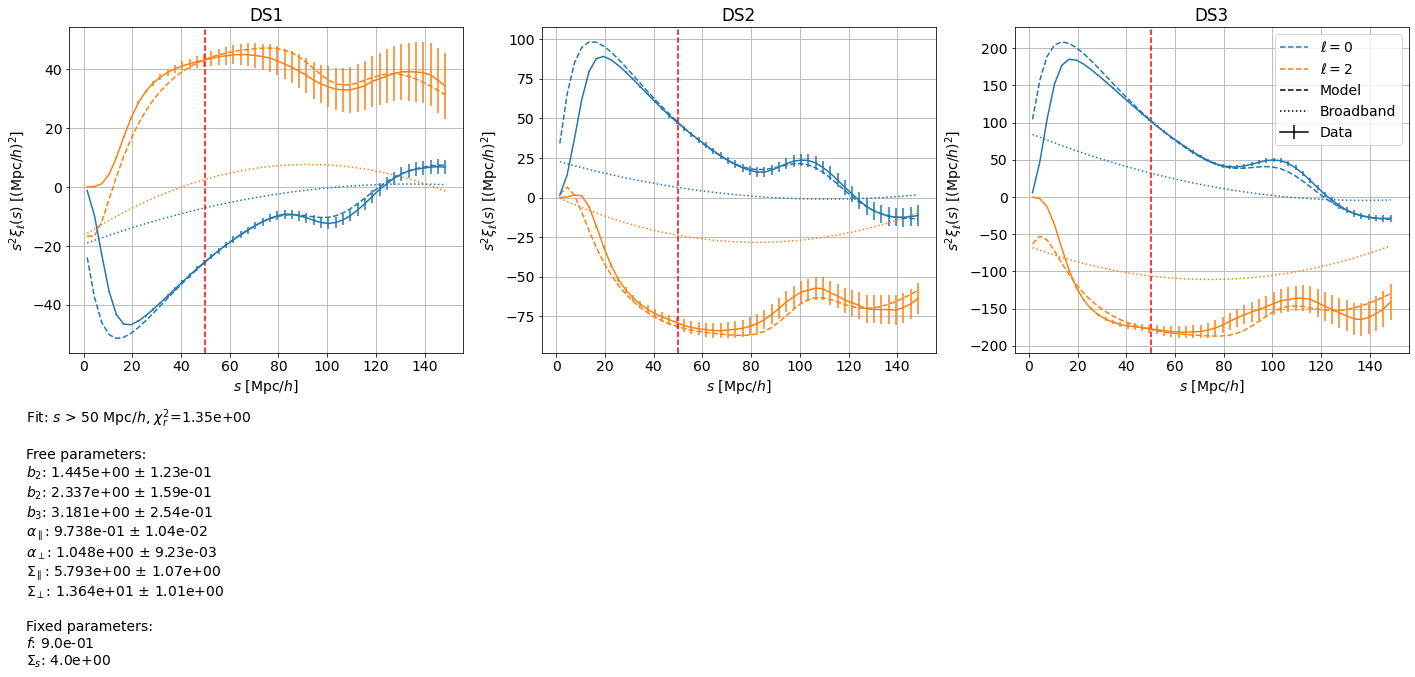

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey = False)

pk_model.plot_model_splits(fig=fig, axes=axes, plot_data=True, show_info=True, show_broadband=True)
#plt.title('Halos-halos')
plt.show()

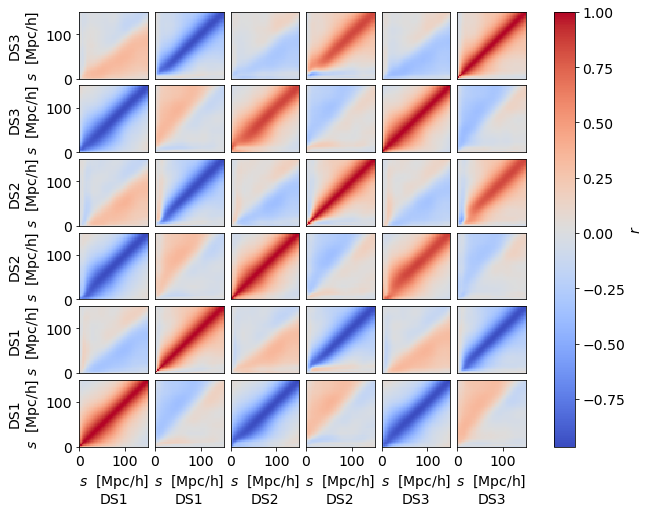

In [17]:
plot_corrcoef(split_cov, ells, s, nsplits)